In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import pymysql
import datetime as dt
from dateutil.relativedelta import relativedelta

In [ ]:
plt.style.use('seaborn')
plt.rc("font", family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

In [25]:
import preprocess
import numpy as np
import pandas as pd
import datetime as dt
import pymysql
from time import gmtime, strftime
import matplotlib.pyplot as plt
import seaborn as sns

# import model

def get_input_data(user) : 
    ts = pd.date_range(start = dt.datetime.today().strftime('%Y-%m-%d'), end = None, periods = 24, freq = 'MS')
    
    # 사용자 입력 정보 전달
    df = pd.DataFrame()
    df['date'] = ts
    df['gu'] = user["gu"]
    df['dong'] = user['dong']
    df['area'] = user['area']
    df['floor'] = user['floor']
    df['tradetype'] = user['tradetype']
    df['doro_trans'] = preprocess.get_road(user['doro'])
    df['year_gap'] = df['date'].apply(lambda x : x.year - user['year'] +1)
    df['floor_level'] = df['floor'].map(lambda x : preprocess.get_floor_level(x))
    df['date'] = df['date'].apply(lambda x : dt.datetime.strftime(x, '%Y-%m-%d'))
    df['credit'] = user["credit"]
    df['pay'] = user["pay"]
    
    # db 데이터 호출
    conn = pymysql.connect(host='mudatabase.cr4neufosdwe.ap-northeast-2.rds.amazonaws.com', user='mu', password="munanodb",
                           charset='utf8', db='mudatabase', port = 3306 )
    cursor = conn.cursor()

    sql = f"""
            select date_format(a.date, '%Y-%m-%d') as date, interest, unemployment, inflation, stock, ex_dallar, 
                    pop, (female_kor / pop) as rate_female, (male_for / pop) as rate_male_f, (female_for / pop) as rate_female_f, (senior / pop) as rate_senior, perhold,
                    oil
            from eco_macro as a
            left join population as b
                on a.date = b.date
            left join oil c
                on a.date = c.date
                    and b.dong = c.dong
                where b.dong = '{input_data['dong']}'
                    and date_format(a.date, '%Y-%m-%d') between '{df['date'][0]}' and '{df['date'][23]}' ;

            """
    cursor.execute(sql)
    cursor.close()
    db_data = pd.DataFrame(cursor.fetchall())
    db_data.columns = ['date', 'interest', 'unemployment', 'inflation', 'stock', 'ex_dollar',
                       'pop', 'rate_female', 'rate_male_f', 'rate_female_f', 'rate_senior', 'perhold',
                       'oil_price']
    


    df = df.merge(db_data, how='inner', on='date')

    df.loc[:,["area","rate_female","rate_male_f","rate_female_f","rate_senior"]] = df.loc[:,["area","rate_female","rate_male_f","rate_female_f","rate_senior"]].astype("float")
    cat_col = ['gu', 'dong', 'tradetype', 'doro_trans', 'floor_level']
    df[cat_col] = df[cat_col].astype("category")
    
    final_col = ["date","credit","pay",'gu', 'dong', 'area', 'floor', 'tradetype', 'interest', 'unemployment',
            'inflation', 'stock', 'ex_dollar', 'pop', 'rate_female', 'rate_male_f',
            'rate_female_f', 'rate_senior', 'perhold', 'doro_trans', 'year_gap',
            'floor_level', 'oil_price']
    
    df = df[final_col]

    global num_col
    num_col = ['area','floor','interest','unemployment','inflation','stock','ex_dollar','pop','rate_female',
               'rate_male_f','rate_female_f','rate_senior', 'perhold', 'year_gap', 'oil_price']
    
    return df[final_col]

In [ ]:


def predict(input_data):
    import model

    df = input_data.copy()
    df = df.drop(["date","pay","credit"], axis = 1)

    model_0, model_1, model_2 = model.load_model()
    scaler_0, scaler_1, scaler_2 = model.load_scaler()

    lst_model = [model_0, model_1, model_2]
    lst_scaler = [scaler_0, scaler_1, scaler_2]

    oof_pred = np.zeros([df.shape[0], ])
    for i in range(len(lst_model)):
        df[num_col] = lst_scaler[i].transform(input_data[num_col])
        oof_pred += lst_model[i].predict(df) 

    output = oof_pred / len(lst_model)
    
    return output, pd.concat([input_data, pd.Series(output, name = "output")], axis =1)

# output, output_df = predict(input_data)


In [ ]:
import model
import numpy as np


# input_data = get_input_data(input_data)

def plot_output(df):
    global output_df

    # plt.style.use('seaborn')
    # plt.rc("font", family='Malgun Gothic')
    # plt.rc('axes', unicode_minus = False)
    
    input_data = get_input_data(df)
    output, output_df = predict(input_data)
    
    # 전세 전환율 5%
    standard_1 = output_df['credit'] + (output_df['pay']*12/0.05)
    # 전세 전환율 2.5% // 법정 전환율
    standard_2 = output_df['credit'] + (output_df['pay']*12/0.025)
    # 집값의 70% 선
    output_df['deadline'] = output_df['area'] * output_df['output'] * 0.7

    # plt.title('')
    plt.figure(figsize = (20,10))
    plt.xticks(rotation=45)
    sns.lineplot(data = output_df, x = "date", y = input_data["area"] * output)
    y_axis = (output_df["output"] * output_df["area"]).mean()
    plt.ylim(y_axis * 0.4, y_axis * 1.3 )
    sns.lineplot(data = output_df, x = 'date', y=standard_1, label ='월세전환율 5%, 서울 평균')
#     sns.lineplot(data = output_df, x = 'date', y=standard_2, label='월세전환율 2.5%, 법정 기준')
    sns.lineplot(data = output_df, x = 'date', y="deadline", label='집값 70%')
    plt.show()
    
    output_plot_id = 'output_plot_{0}.png'.format(strftime("%Y-%m-%d_%H:%M:%S", gmtime()))
#     plt.savefig(output_plot_id)
    
    dict_pred = { 'file' : output_plot_id,
                  'pred_1' : standard_1[0] / (output_df.loc[0,"area"]* output_df.loc[0,"output"]),
                  'pred_2' : standard_2[0] / (output_df.loc[output_df.shape[0]-1,"area"] * output_df.loc[output_df.shape[0]-1,"output"])
                }
    
#     print(dict_pred)
    return dict_pred



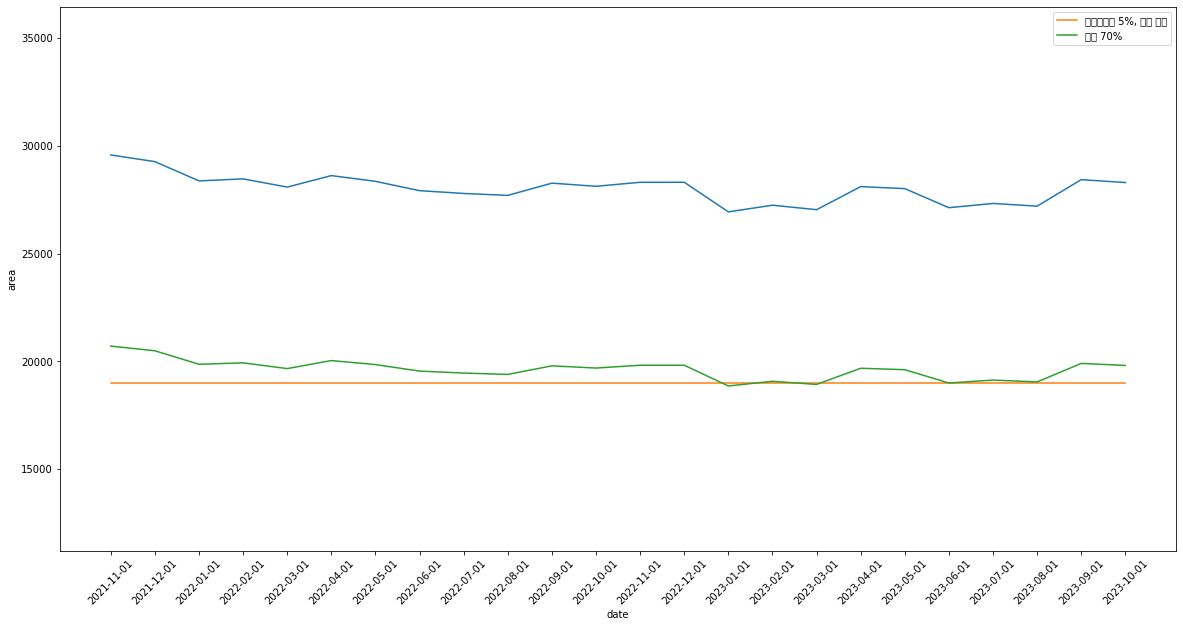

In [63]:
user_input = {}
user_input['gu'] = '영등포구'
user_input['dong'] = '영등포본동'
user_input['doro'] = '국회대로56길'
user_input['area'] = 37.51
user_input['floor'] = 2
user_input['tradetype'] =  1
user_input['year'] = 2019
user_input['credit'] = 1000
user_input['pay'] = 75

preds= plot_output(user_input)